In [1]:
# imports libraries
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import math
import sklearn.decomposition as dcmp
import pyaudio
import csv
import IPython

%matplotlib inline 

# Grabs the preprocessing and automatic_sync files
sys.path.append(os.path.join(os.pardir,'pythonCode'))
import preprocessing as pp
import automatic_sync as autoS
import audio

In [2]:
def sync_dataset(dataset,indexName,names,max_iter = 2,mask=[0,1]):
    '''
    offsets, sDataset = sync_dataset(cDataset,names,max_iter = 2). Syncs the input dataset (dictionary) 
    with corresponding keys (names), recursively determines relative offsets using the cross 
    correlation. 
    Inputs:
        cDataset (dict) - dictionary with raw audio data, each key corresponds to an (Ni,2) array of 1D signals.
        indexName(str) - channel that will be the basis of the syncronization
        names (list) - keys to the dictionary (data will be synced to names[0])
        max_iter (optional) - maximum number of iterations to be performed.
        mask (optional) - range of values to consider in syncing. Relative values ranging from [0,1], list size (2,)
    Outputs:
        sDataset (dict) - synced dataset (each entry has the same length)
        final_offsets (dict) - final signal offset values
        
    '''
    
    # copies original dataset to work on the copy
    origDataset = dataset.copy()
    cDataset = dataset.copy()
    
    # initializes variables
    iter_count = 0
    final_offsets ={}
    mask_offset = 0
    start_index ={}
    
    # apllies the mask to the indexName values in the dataset
    for name in names:
        Npoints = len(cDataset[name][:,0])
        startInd = int(np.floor(Npoints*mask[0]))
        endInd = int(np.ceil(Npoints*mask[1]))
        cDataset[name] = cDataset[name][startInd:endInd,:]
        start_index[name] = startInd
        final_offsets[name] = 0
        
    # initializes final offsets
    #mask_offset = startInd
    #print(mask_offset)
        
    offsets =  autoS.find_offset(cDataset,indexName,[k  for k in names if k != indexName])
    
    if abs(sum(offsets.values())) == 0:
        final_offsets = offsets
    else:
        # syncs the masked dataset
        while abs(sum(offsets.values())) > 0 and iter_count < max_iter:

            #print(offsets)
            endInd = np.Inf
            startInd = 0

            for name in names:
                if offsets[name] > startInd:
                    startInd = offsets[name]
                if len(cDataset[name][:,0]) < endInd:
                    endInd = len(cDataset[name][:,0])

            for name in names:
                cDataset[name] = cDataset[name][startInd-offsets[name]:endInd-offsets[name],:]
                final_offsets[name] = final_offsets[name] + startInd-offsets[name]

            offsets = autoS.find_offset(cDataset,indexName,[k  for k in names if k != indexName])
            iter_count += 1
        
        print(offsets.values())
        assert sum(offsets.values()) == 0, print(offsets)
    
        # Modifies the original dataset based on the start location identified through syncing
        #
        #            offset    start Ind
        # |----------------|--|--------------| signal 1
        #                  |
        # |------- L1 -----|------ L2 -------|
        #                  |
        #                  |     start Ind
        #    |-------------|----|-----------------|  signal 2
        #                  |
        #    |----- L1 ----|--------- L2 ---------|
        #                  |
        #                  |
        #
        #    |------------------------------| final signal length
        #

        Lend = np.Inf
        Lstart = np.Inf
        Lref = start_index[indexName]+final_offsets[indexName]

        for name in names:
            L1 = start_index[name]+final_offsets[name]
            L2 = len(origDataset[name][:,0]) - L1

            Lend= min([Lend,L2])
            Lstart = min([Lstart,L1])
            


        for name in names:
            L1 = start_index[name]+final_offsets[name]
            this_range = range(L1-Lstart,L1+Lend)
            origDataset[name] = origDataset[name][this_range,:]
            final_offsets[name] = Lref-L1
    
    return final_offsets, origDataset

In [3]:
def test_sync(signal,shift,mask = [0,1]):
    ''' Bool = test_shift(signal,shift) Tests the find_offset function by:
        (1) Takes a signal size (N,) as input
        (2) Aritifically shifts signal by counts input into function
        (3) Calls the sync_data function to determine signal offsets
        (4) Returns "True" if the identified offset = input shift
            Returns "False" if the identified offset != input shift
    '''
    # makes some "phony" data
    phonyData = {}
    phonyData['Original'] = np.transpose(np.vstack((signal,signal)))
    
    if shift < 0:
        # negtive shift
        phonyData['Shifted'] = np.vstack((np.zeros((abs(shift),2)),phonyData['Original'])) 
    else:
        # positive shift
        phonyData['Shifted'] = phonyData['Original'][shift:,:] 
        
    phonyOffsets, origDataset, cDataset = sync_dataset(phonyData,'Original',['Original','Shifted'],mask= mask)

    #print(phonyOffsets) # prints the offsets in counts
    if phonyOffsets['Shifted'] == shift:
        return True
    else:
        print(phonyOffsets['Shifted'])
        print(shift)
        return False

In [4]:
# Determines which cameras will be selected (['Bents'],['Camera Location'],['Motion #'])
filt = (None,None,['17']) # Selects the bent 1 camera used during motion 18

# now reads in the datafile from the raw data folder
rawDataPath = os.path.join(os.pardir,'rawData')
files = glob.glob(os.path.join(rawDataPath, '*.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)

# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);
# Reads the .wav files from the list generted by getKeys
(names,rawDataset) = pp.readWAV(rawDataPath,audioFiles);

Opening GP_B2_SU_17 ...
Opening GP_B3_SL_17 ...


In [5]:
# Compares syncing with the start and end portions to syncing using the entire signal 
final_offsets1, syncData1, cData1 = sync_dataset(rawDataset,names[0],names)
print(final_offsets1)

final_offsets2, syncData2,cData2 = sync_dataset(rawDataset,names[0],names,mask=[0,0.4])
print(final_offsets2)

final_offsets3, syncData3,cData3 = sync_dataset(rawDataset,names[0],names,mask=[0.7,1])
print(final_offsets3)

dict_values([0, 0])
{'GP_B2_SU_17': 0, 'GP_B3_SL_17': -68856}
dict_values([0, 0])
{'GP_B2_SU_17': 0, 'GP_B3_SL_17': -65774}
dict_values([0, 0])
{'GP_B2_SU_17': 0, 'GP_B3_SL_17': -64678}


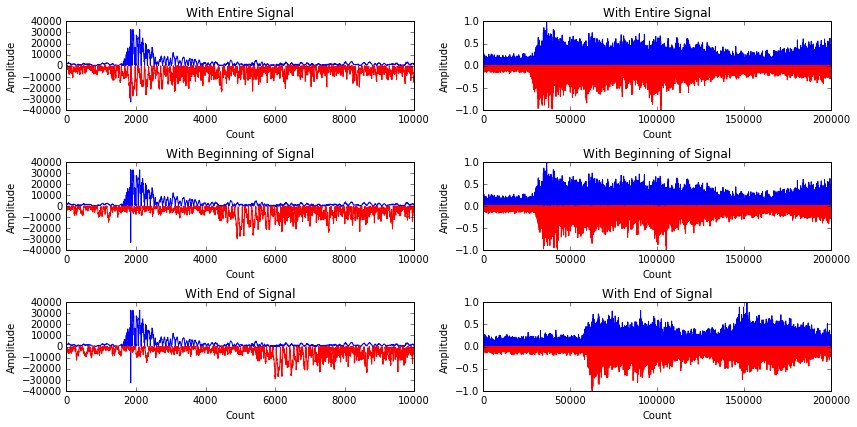

In [8]:
# Plots the results for comparison
this_range = range(2380000,2390000)

fig = plt.figure(figsize = (12,6) )

plt.subplot(3,2,1)
plt.plot(abs(syncData1[names[0]][this_range,0]),'b')
plt.plot(-abs(syncData1[names[1]][this_range,0]),'r')
plt.xlabel('Count')
plt.ylabel('Amplitude')
plt.title('With Entire Signal')

plt.subplot(3,2,2)
plt.plot(abs(cData1[names[0]][1200000:1400000,0])/max(abs(cData1[names[0]][1200000:1400000,0])),'b')
plt.plot(-abs(cData1[names[1]][1200000:1400000,0])/max(abs(cData1[names[1]][1200000:1400000,0])),'r')
plt.xlabel('Count')
plt.ylabel('Amplitude')
plt.title('With Entire Signal')

plt.subplot(3,2,3)
plt.plot(abs(syncData2[names[0]][this_range,0]),'b')
plt.plot(-abs(syncData2[names[1]][this_range,0]),'r')
plt.xlabel('Count')
plt.ylabel('Amplitude')
plt.title('With Beginning of Signal')

plt.subplot(3,2,4)
plt.plot(abs(cData2[names[0]][1200000:1400000,0])/max(abs(cData2[names[0]][1200000:1400000,0])),'b')
plt.plot(-abs(cData2[names[1]][1200000:1400000,0])/max(abs(cData2[names[1]][1200000:1400000,0])),'r')
plt.xlabel('Count')
plt.ylabel('Amplitude')
plt.title('With Beginning of Signal')

plt.subplot(3,2,5)
plt.plot(abs(syncData3[names[0]][this_range,0]),'b')
plt.plot(-abs(syncData3[names[1]][this_range,0]),'r')
plt.xlabel('Count')
plt.ylabel('Amplitude')
plt.title('With End of Signal')

plt.subplot(3,2,6)
plt.plot(abs(cData3[names[0]][100000:300000,0])/max(abs(cData3[names[0]][100000:300000,0])),'b')
plt.plot(-abs(cData3[names[1]][100000:300000,0])/max(abs(cData3[names[1]][100000:300000,0])),'r')
plt.xlabel('Count')
plt.ylabel('Amplitude')
plt.title('With End of Signal')

    
fig.tight_layout() 

plt.savefig('sync.pdf',format = 'pdf', transparent = True)

In [7]:
# Tests to see if syncronizng a channel against itself with an offset produces the right signal 
# + and - offsets
# different mask values

print(test_sync(rawDataset[names[0]][:,0],200,mask = [0,1]))
print(test_sync(rawDataset[names[0]][:,0],-200,mask = [0,1]))

print(test_sync(rawDataset[names[0]][:,0],200,mask = [.7,1]))
print(test_sync(rawDataset[names[0]][:,0],-200,mask = [.7,1]))

print(test_sync(rawDataset[names[0]][:,0],200,mask = [0,0.4]))
print(test_sync(rawDataset[names[0]][:,0],-200,mask = [0,0.4]))

dict_values([0, 0])
True
dict_values([0, 0])
True
dict_values([0, 0])
True
dict_values([0, 0])
True
dict_values([0, 0])
True
dict_values([0, 0])
True
